# Toward the Eshelby's elliptical inhomogeneity problem: a composite disk

We consider a composite disk in 2d elasticity.

We consider a circular inclusion (radius: $a$, Lamé coefficients: $\lambda_{\mathrm i}$, $\mu_{\mathrm i}$) embedded in a homogeneous, circular matrix (radius: $R$, Lamé coefficients: $\lambda_{\mathrm m}$, $\mu_{\mathrm m}$). Both disks are concentric.

The boundary of the matrix is subjected to the prescribed displacement

\begin{equation*}
u_x = y\quad\text{and}\quad u_y=x.
\end{equation*}

These boundary conditions are known as “kinematically uniform boundary conditions”, the general form of which is

\begin{equation*}
\mathbf{u} = \overline{\boldsymbol\varepsilon}\cdot\mathbf{x},
\end{equation*}

where the *macroscopic strain* $\overline{\boldsymbol\varepsilon}$ is in the present case a unit shear

\begin{equation*}
\overline{\boldsymbol\varepsilon}=\mathbf{e}_x\otimes\mathbf{e}_y+\mathbf{e}_y\otimes\mathbf{e}_x.
\end{equation*}



## Homework

Write a code that solve the problem for a matrix with Young modulus and Poisson ratio $E_m = 1.0$,
$\nu_m = 0.3$ and a inclusion with poisson ratio $\nu_i = 0.3$ and $E_i=10E_m$. The loading is given by the displacement imposed on the external boundary of the matrix:
\begin{equation*}
u_x = y\quad\text{and}\quad u_y=x.
\end{equation*}
Plot the displaced configuration of the structure and the Von Mises stress.
You can compare with the anlytical solution provided in the notebook `Circular_inhomogeneity-shear.ipynb`.

*Hint:* You find below an help for starting, with the mesh and the subdomains. You can get inspiration form the examples treated in class and from the fenics tutorial for the rest of the code. 


### Help: Mesh with subdomains
We give below the code to produce the mesh of the domain, which is a disk containing a concentric inclusion. 

*Comments*
- We use the library [mshr](https://bitbucket.org/fenics-project/mshr/wiki/Home) to generate the mesh. This is not optimal, but practical. More complex meshes can be generated with [gmsh](https://gmsh.info) and imported (not needed here). 
- The discretization of the geometric primitives (ellipse, circle) are defined in terms of number of segments. As we want to control the *size* of the elements, we need to compute the perimeter of the entities first. We use `mshr.Ellipse`, because we will change the shape in a second step of the project
- We use `Subdomains` to deal with multiple materials. Details about this point can be found in Section 4.3 of the [fenics tutorial](https://fenicsproject.org/pub/tutorial/pdf/fenics-tutorial-vol1.pdf).

In [1]:
%matplotlib inline
import dolfin 
import dolfin as df
import matplotlib.pyplot as plt
import mshr
import numpy as np
import scipy.special
import ufl


In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

# I- Premiere Résolution Numérique pour une inclusion circulaire 

##  Maillage

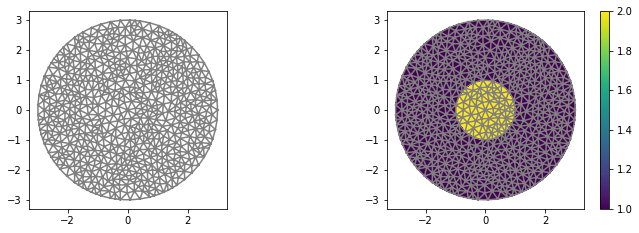

In [3]:
MATRIX_ID = 1
INHOMOGENEITY_ID = 2

a=1
gamma=3
def creation_maillage(a=1.0,b=1.0,gamma=3, k_resolution=2.0): 
    
    R = gamma*a # Radius of domain
    h = a/k_resolution # Size of elements
    
    circle_perimeter = 2*np.pi*R
    e_sqr = 1.-min(a, b)/max(a, b)
    ellipse_perimeter = 4*a*scipy.special.ellipe(e_sqr)
    origin = dolfin.Point(0., 0.)
    Omega_i = mshr.Ellipse(origin, a, b,
                           int(np.ceil(ellipse_perimeter/h)))
    Omega = mshr.Circle(origin, R,
                        int(np.ceil(circle_perimeter/h)))
    Omega.set_subdomain(MATRIX_ID, Omega-Omega_i)
    Omega.set_subdomain(INHOMOGENEITY_ID, Omega_i)
    mesh = mshr.generate_mesh(Omega, resolution=2*R/h)
    subdomain_data = dolfin.MeshFunction("size_t", mesh, dim=mesh.geometric_dimension(), value=mesh.domains())
    dx = dolfin.Measure("dx",
                    domain=mesh,
                    subdomain_data=subdomain_data)
    ds = dolfin.Measure("ds", domain=mesh)
    return mesh,subdomain_data,dx,ds

a,b=1,1
gamma =3 
k_resolution=3
mesh,subdomain_data,dx,ds = creation_maillage(a,b,gamma,k_resolution)
R    =  gamma * a

plt.subplot(220+1)
dolfin.plot(mesh)

plt.subplot(220+2)
plt.colorbar(dolfin.plot(subdomain_data))
dolfin.plot(mesh)

We provide also the `subdomain_data` and measures incorporating them, that will be useful to identify the parts of the domains (see FEniCS tutotiral sec.4.3)

For example you can get the areas of each region as folllow:

In [4]:
keys = ["everywhere", INHOMOGENEITY_ID, MATRIX_ID]
areas = {key: dolfin.assemble(dolfin.Constant(1.)*dx(key)) for key in keys}
areas
for region, area in areas.items():  
        print("The area of the region {} is {:04.2f}".format(region, area))

The area of the region everywhere is 28.22
The area of the region 2 is 3.08
The area of the region 1 is 25.13


## Espace des Fonction V :

In [5]:
def espace_des_fonction(mesh=mesh,degree = 1):
    element = df.VectorElement("P", df.triangle, degree = degree)

    # Create function space
    V = df.FunctionSpace(mesh, element)

    # Create test and trial functions, and source term
    u = df.TrialFunction(V)
    v = df.TestFunction(V)
    
    return V,u,v
V,u,v =espace_des_fonction(mesh=mesh,degree = 1)

## Parametres Pysique 

In [6]:
# force volumique :
rho,g = 1.0,0.0
# dimensions du disque 
R_in,R_out = a,R
#caracteristique des materiaux 
E_m,ν_m = 1.0,0.3
E_i,ν_i = 10*E_m,0.3


## Conditions aux Limites :

\begin{equation*}
u_x = y\quad\text{and}\quad u_y=x.
\end{equation*}
Sur $\partial \Omega_1$ 

In [7]:
ud = df.Expression(('x[1]', 'x[0]'), degree =1)

### Resolution du probleme avec la class eshelby_num

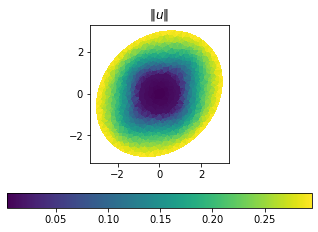

In [8]:
from eshelby_num import EshelbyDisk_num

# creation du probleme :
Prblm = EshelbyDisk_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_out,E_m,E_i, ν_i, ν_m,ud)

#resolution 
usol=Prblm.resolution()

#affichage :
plt.subplot(220+1)
plt.colorbar(df.plot((10**(-1))*usol, mode="displacement",title=r"$\Vert u \Vert$",\
                     wireframe = True),orientation="horizontal")
plt.show()



#### deplacements max : 

In [9]:
def norme_elliptique(x,y,a,b):
    return ((x**2)/a**2) + ((y**2)/b**2) 

def deplacement_max(mesh,usol,a,b):
    mesh_points=mesh.coordinates()
    u_array_inclusion=np.array([usol(df.Point(x,y)) for x,y in mesh_points if norme_elliptique(x,y,a,b)<=1 ])
    u_array_matrix=np.array([usol(df.Point(x,y)) for x,y in mesh_points if norme_elliptique(x,y,a,b)>1 ])
    
    return np.max(u_array_inclusion), np.max(u_array_matrix)
    

In [10]:
deplacement = deplacement_max(mesh,usol,a,b)

print("déplacement maximale dans l'inclusion :",deplacement[0] )
print("déplacement maximale dans la matrice  :",deplacement[1] )


déplacement maximale dans l'inclusion : 0.18233955048028147
déplacement maximale dans la matrice  : 3.0


## Post Traitement

In [11]:
from Post_traitement import Eshelby_Post_treat 
res_treat = Eshelby_Post_treat(mesh,a,b,usol,E_m,E_i, ν_i, ν_m)

## affichage des champs de deformation $\epsilon$ :

la valeur maximale de la deformation  $ε_{xx} $=  0.5782400306431802
la valeur maximale de la deformation  $ε_{xy} $=  1.425038976938629
la valeur maximale de la deformation  $ε_{yy} $=  0.6544608353652928


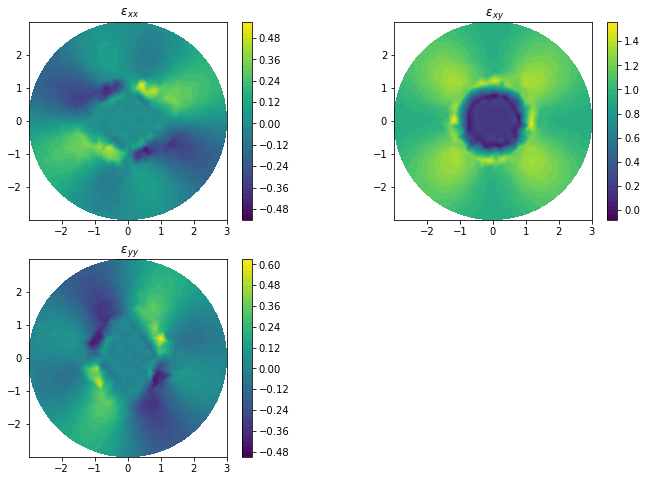

In [12]:
res_treat.plot_all_strain()

## avarage strain et Deviation 

In [13]:
print("*Dans l'inclusion :")
res_treat.average_strain(dx(INHOMOGENEITY_ID))
print('')
res_treat.diviation_strains(dx(INHOMOGENEITY_ID))
print('')
print('')
print("Dans la Matrix:")
res_treat.average_strain(dx(MATRIX_ID))
print('')
res_treat.diviation_strains(dx(MATRIX_ID))


*Dans l'inclusion :
  la deformation moyenne suivant  ε_{xx} est < e11>= -0.00014411114014142572
  la deformation moyenne suivant  ε_{xy} est < e12>= 0.18040078386714534
  la deformation moyenne suivant  ε_{yy} est < e22>= 5.8967911580047036e-05

  la deviation  suivant ε_{xx} est = -14.409114850707942
  la deviation  suivant ε_{xy} est = 0.013875133258836325
  la deviation  suivant ε_{yy} est = 36.45763107530447


Dans la Matrix:
  la deformation moyenne suivant  ε_{xx} est < e11>= 1.768754971927611e-05
  la deformation moyenne suivant  ε_{xy} est < e12>= 1.1005939018385886
  la deformation moyenne suivant  ε_{yy} est < e22>= -7.2374548344558825e-06

  la deviation  suivant ε_{xx} est = 7428.7447532892975
  la deviation  suivant ε_{xy} est = 0.09214105415248992
  la deviation  suivant ε_{yy} est = -18152.00321459196


array([ 7.42874475e+03,  9.21410542e-02, -1.81520032e+04])

## affichage des champs de contrainte $\sigma$ :

la valeur maximale de la contrainte $σ_{xx}$=  1.0335188504231652
la valeur maximale de la contrainte $σ_{xy}$=  1.4950201169585124
la valeur maximale de la contrainte $σ_{yy}$=  0.980830577525133
la valeur maximale de la contrainte equivalente $ σ_{vm} $   = 2.9914951018018248


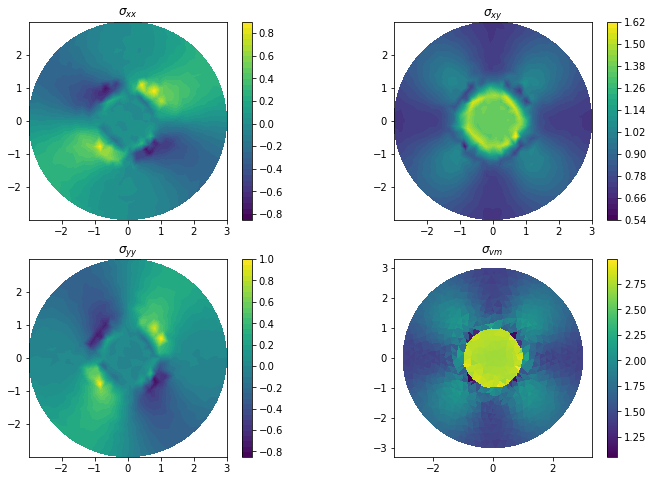

In [14]:
with_von_mises =True
res_treat.plot_all_stress(with_von_mises)

## avarage stress et Deviation 

In [15]:
print("*Dans l'inclusion :")
res_treat.average_stress(dx(INHOMOGENEITY_ID))
print('')
res_treat.diviation_stress(dx(INHOMOGENEITY_ID))
print('')
print('')
print("Dans la Matrix:")
res_treat.average_stress(dx(MATRIX_ID))
print('')
res_treat.diviation_stress(dx(MATRIX_ID))

*Dans l'inclusion :
  la contrainte moyenne suivant σ_{xx} est < sig11>= -0.0015997581658650799
  la contrainte moyenne suivant σ_{xy} est < sig12>= 1.3876983374395806
  la contrainte moyenne suivant σ_{yy} est < sig22>= -3.761161416143878e-05

  la deviation  suivant σ_{xx} est = -20.396223683629042
  la deviation  suivant σ_{xy} est = 0.013875133258836414
  la deviation  suivant σ_{yy} est = -856.4238200156226


Dans la Matrix:
  la contrainte moyenne suivant σ_{xx} est < sig11>= 1.963470837145513e-05
  la contrainte moyenne suivant σ_{xy} est < sig12>= 0.8466106937219909
  la contrainte moyenne suivant σ_{yy} est < sig22>= 4.616279455098064e-07

  la deviation  suivant σ_{xx} est = 10560.107846862418
  la deviation  suivant σ_{xy} est = 0.09214105415248998
  la deviation  suivant σ_{yy} est = 449499.4691811274


array([1.05601078e+04, 9.21410542e-02, 4.49499469e+05])

# II- Résolution analytique  

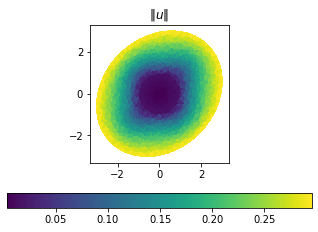

In [16]:
from eshelby import EshelbyDisk

## résolution analytique 
def solution_analytique_project(mesh,R_out,R_in, E_i,E_m, ν_i, ν_m,degree=1):
    
    solution = EshelbyDisk(R_out/R_in, E_i/E_m, ν_i, ν_m)

    ## Solution analytique 
    u_ref = solution.to_expression(R_in)
    # Execute this to obtain the plot of the analytical solution

    V_ref = dolfin.VectorFunctionSpace(mesh, 'P', degree)
    #avec_interpolate :
    #u_ref_num = dolfin.interpolate(u_ref, V_ref)
    # avec_project : 
    u_ref_p = df.project(u_ref,V_ref)
    
    return u_ref_p,u_ref


u_ref_p,u_ref=solution_analytique_project(mesh,R_out,R_in, E_i,E_m, ν_i, ν_m,degree=1)
#affichage :
plt.subplot(220+1)
plt.colorbar(df.plot((10**(-1))*u_ref_p, mode="displacement",title=r"$\Vert u \Vert$",\
                     wireframe = True),orientation="horizontal")
plt.show()

#### calcul se lerreur

## affichage de la contrainte equivalente de Vom Mises $\sigma_{vm}$ :

In [17]:
error_L2=df.errornorm(u_ref_p, usol, 'L2')
print('la norme L2 de l\'erreur  de la solution numérique est',error_L2)

la norme L2 de l'erreur  de la solution numérique est 0.026441329568907008


## Comparaison Numérique et analytique 

In [18]:
# calcul du déplacement u_y sur la y=y_face

liste_x = np.linspace(-R_out, R_out, num=50)
liste_x = liste_x[1:-1]
y_face =0
y=y_face
u_formule = 0.0*liste_x
u_numerique = 0.0*liste_x
for k, x_k in enumerate(liste_x):
    u_formule[k] = u_ref([x_k,y])[1]
    u_numerique[k]  = usol(x_k, y)[1]
    

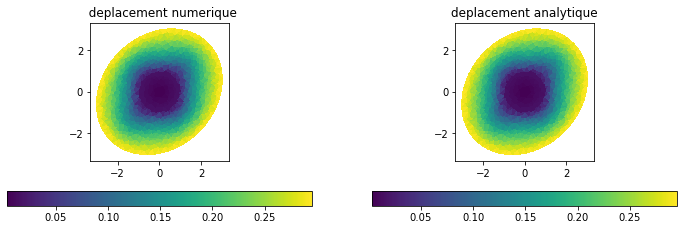

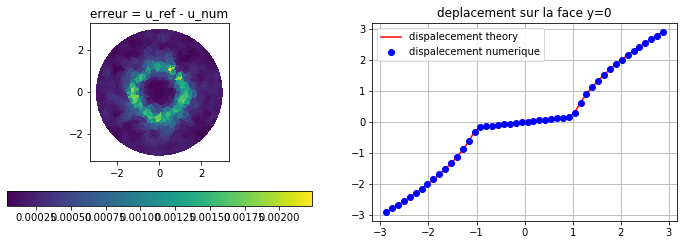

In [19]:
#affichage :
plt.subplot(221)
plt.colorbar(df.plot((10**(-1))*usol, mode="displacement",title=r"  deplacement numerique",\
                     wireframe = True),orientation="horizontal")


#affichage :
plt.subplot(222)
plt.colorbar(df.plot((10**(-1))*u_ref_p, mode="displacement",title=r"deplacement analytique",\
                     wireframe = True),orientation="horizontal")
plt.show()

#affichage :
plt.subplot(223)
plt.colorbar(df.plot((1E-1)*(usol-u_ref_p), mode="displacement",title=r"erreur = u_ref - u_num",\
                     wireframe = True),orientation="horizontal")

plt.subplot(224)
plt.plot(liste_x, u_formule, label='dispalecement theory',color='red')
plt.plot(liste_x, u_numerique, 'o', label='dispalecement numerique',color='blue')
plt.title('deplacement sur la face y=0')
plt.grid()


plt.legend()


plt.show()
            

# III-  Etude taux de Convergence 

In [20]:
def calcul_pente(X_arr,Y_arr):
    n=len(X_arr)
    n=n-1
    pente = 0
    for i in range(n):
        pente+=(Y_arr[i+1]-Y_arr[i])/(X_arr[i+1]-X_arr[i])
    return pente/n
    

In [21]:

%%time
resolutions_du_maillage = np.array([i for i in range(3,5)]) # dans le rapport nous avons mis range(3,25) temps = 5 min
degrees = np.array([1,2,3])
errorH1 = np.array([])
Error_H1_PI=np.zeros((len(degrees),len(resolutions_du_maillage)))

# solution anaytique :
solution = EshelbyDisk(R_out/R_in, E_i/E_m, ν_i, ν_m)
u_ref = solution.to_expression(R_in)
     
for i,degree in enumerate(degrees) :
    degree = int(degree)
 
    for j,resolution in enumerate(resolutions_du_maillage) :
        resolution = int(resolution)
        # maillage 
        mesh,subdomain_data,dx,ds = creation_maillage(a=1.0,b=1.0,gamma=3,k_resolution=resolution)
        
        
        # Solution numerique 
        V,u,v =espace_des_fonction(mesh,degree)
           
        Prblm = EshelbyDisk_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_out,E_m,E_i, ν_i, ν_m,ud)
        usol = Prblm.resolution()
        
        #error H1
        error_H1=df.errornorm(u_ref, usol, 'H1')
        Error_H1_PI[i,j]= error_H1


## Plot la covergence 
# en log log
resolutions_du_maillage_log =np.log(resolutions_du_maillage)
Error_H1_PI_log = np.log(Error_H1_PI)



CPU times: user 5.71 s, sys: 1.66 s, total: 7.37 s
Wall time: 5.03 s


Pour P1, la pente est de :  -1.0545470461282975
Pour P2, la pente est de :  -1.496417820254299
Pour P3, la pente est de :  -1.5197446733705458


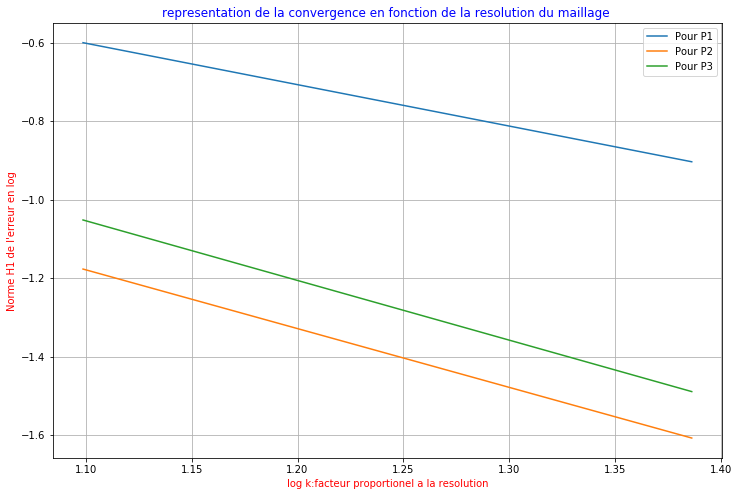

[[0.5485767  0.40502663]
 [0.30816384 0.20036466]
 [0.34920231 0.22552886]]


In [22]:

#pente :
for i in range(3):
    print("Pour P"+str(i+1)+", la pente est de : ", calcul_pente(resolutions_du_maillage_log,Error_H1_PI_log[i,:]) )
    
    
#plot log log    

plt.plot(resolutions_du_maillage_log,Error_H1_PI_log[0,:],label ="Pour P1")
plt.plot(resolutions_du_maillage_log,Error_H1_PI_log[1,:],label ="Pour P2")
plt.plot(resolutions_du_maillage_log,Error_H1_PI_log[2,:],label ="Pour P3")
#plt.yscale("log")
plt.xlabel("log k:facteur proportionel a la resolution",color="red")
plt.ylabel("Norme H1 de l'erreur en log",color="red")
plt.title("representation de la convergence en fonction de la resolution du maillage ",color="blue")
plt.grid()
plt.legend()
plt.show()
print(Error_H1_PI)


# IV- Etude de la convergence en fonction de $\nu$ 

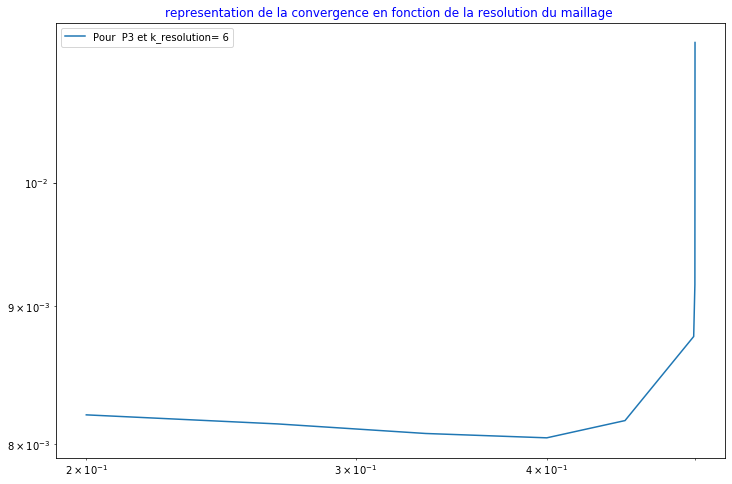

[0.00820453 0.00814149 0.00807533 0.00804547 0.00804547 0.00816466
 0.00877099 0.00916771 0.01126806]
CPU times: user 47.6 s, sys: 11 s, total: 58.6 s
Wall time: 44.1 s


In [23]:
%%time
# on fixe degree = 2 et k_resolution= 10 puis on fais varié nu 

# interval de nu
nu_array1 =np.linspace(0.2,0.4,4) #pour rapport nous avons mis 40 pointes
nu_array2 =np.linspace(0.4,0.5,3)#pour rapport nous avons mis 30 pointes
nu_array2[-1]= 0.499
nu_array2= np.append(nu_array2,[0.4999,0.499999999])
# interval de nu
nu_array = np.concatenate((nu_array1,nu_array2))

resolution = 6
degree =3

errorL2_array = np.array([])

for i,nu in enumerate(nu_array):
    
        # maillage 
        mesh,subdomain_data,dx,ds = creation_maillage(a=1.0,gamma=3,k_resolution=resolution)
        # solution anaytique :
        ν_i,ν_m =nu,nu
        solution = EshelbyDisk(R_out/R_in, E_i/E_m, ν_i, ν_m)
        u_ref = solution.to_expression(R_in)
     
        # Solution numerique 
        V,u,v =espace_des_fonction(mesh,degree)
           
        Prblm = EshelbyDisk_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_out,E_m,E_i, ν_i, ν_m,ud)
        usol = Prblm.resolution()
        
        #error L2
        error_L2=df.errornorm(u_ref, usol, 'L2')
        errorL2_array= np.append(errorL2_array,error_L2)
      
    
## Plot la covergence 
plt.plot(nu_array,errorL2_array,label ="Pour  P"+str(degree)+" et k_resolution= "+str(resolution))
plt.yscale("log")
plt.xscale("log")
plt.title("representation de la convergence en fonction de la resolution du maillage ",color="blue")
plt.legend()
plt.show()
print(errorL2_array)


deformation pour nu =  0.499999999
la valeur maximale de la deformation  $ε_{xx} $=  1.0833795021427877
la valeur maximale de la deformation  $ε_{xy} $=  2.538530985037196
la valeur maximale de la deformation  $ε_{yy} $=  1.035363079395406


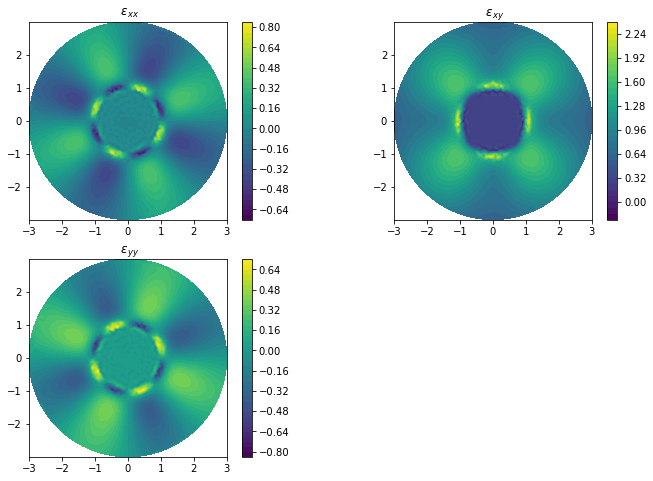

In [24]:
print('deformation pour nu = ',ν_i )
res_treat = Eshelby_Post_treat(mesh,a,b,usol,E_m,E_i, ν_i, ν_m)
res_treat.plot_all_strain()


# V- geometrie inclusion elliptique (a$\ne$b)

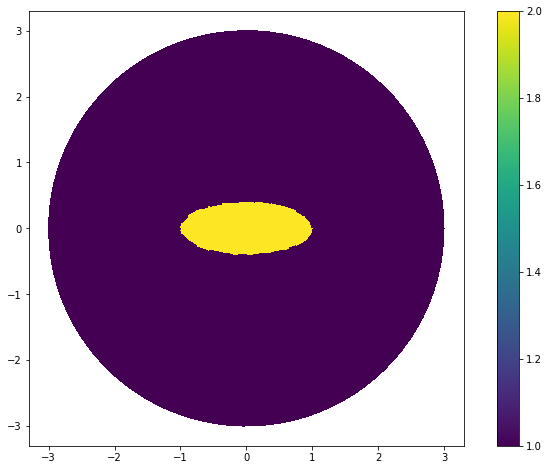

The area of the region everywhere is 28.25
The area of the region 2 is 1.24
The area of the region 1 is 27.01


In [25]:
# creation mesh
a,b = 1,0.4
R_in =a
gamma = 3
R = gamma*a
R_out =R
k_resolution=5
mesh,subdomain_data,dx,ds = creation_maillage(a,b,gamma,k_resolution)
plt.colorbar(dolfin.plot(subdomain_data))
#dolfin.plot(mesh)
plt.show()
keys = ["everywhere", INHOMOGENEITY_ID, MATRIX_ID]

areas = {key: dolfin.assemble(dolfin.Constant(1.)*dx(key)) for key in keys}
areas
for region, area in areas.items():  
        print("The area of the region {} is {:04.2f}".format(region, area))


## Solution numerique

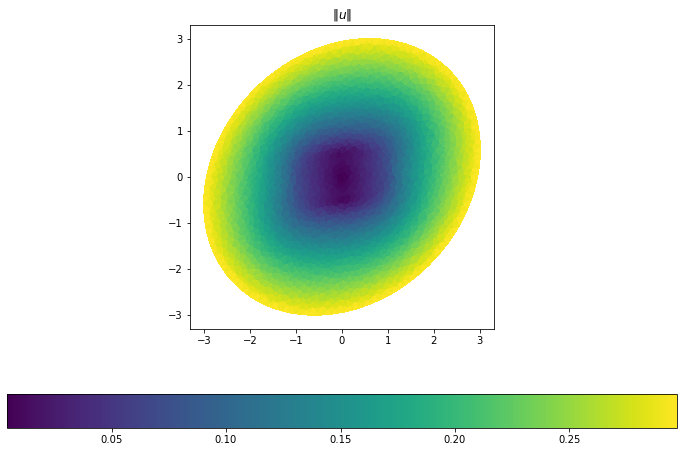

In [26]:
from eshelby_num import EshelbyDisk_num as Eshelbyelliptical_num

#caracteristique des materiaux 
E_m,ν_m = 1.0,0.3
E_i,ν_i = 10*E_m,0.3

# creation du probleme :
V,u,v =espace_des_fonction(mesh,1)

Prblm = Eshelbyelliptical_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_out,E_m,E_i, ν_i, ν_m,ud)

#resolution 
usol=Prblm.resolution()

#affichage :
plt.colorbar(df.plot((10**(-1))*usol, mode="displacement",title=r"$\Vert u \Vert$",\
                     wireframe = True),orientation="horizontal")
plt.show()




## POST Traitemant

In [27]:
from Post_traitement import Eshelby_Post_treat 
res_treat = Eshelby_Post_treat(mesh,a,b,usol,E_m,E_i, ν_i, ν_m)

## affichage des champs de deformation $\epsilon$ :


la valeur maximale de la deformation  $ε_{xx} $=  0.6683580897235398
la valeur maximale de la deformation  $ε_{xy} $=  1.3703278072645553
la valeur maximale de la deformation  $ε_{yy} $=  0.33778761875020435


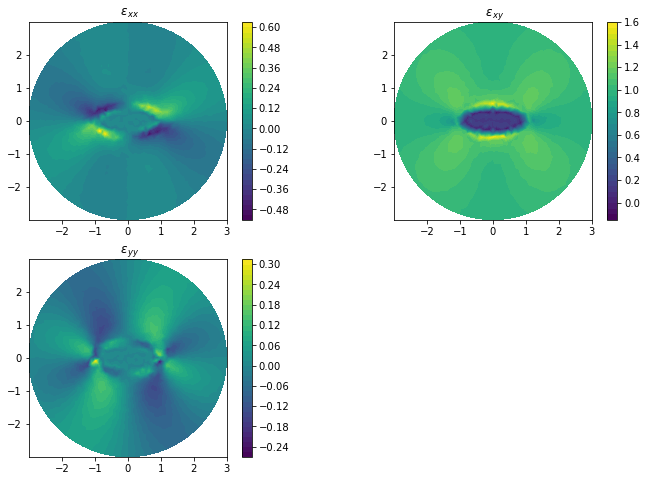

In [28]:
res_treat.plot_all_strain()


## affichage des champs de contrainte $\sigma$ :

la valeur maximale de la contrainte $σ_{xx}$=  0.9347050775872976
la valeur maximale de la contrainte $σ_{xy}$=  1.3496420856326614
la valeur maximale de la contrainte $σ_{yy}$=  0.7617928230636624
la valeur maximale de la contrainte equivalente $ σ_{vm} $   = 2.699301889096084


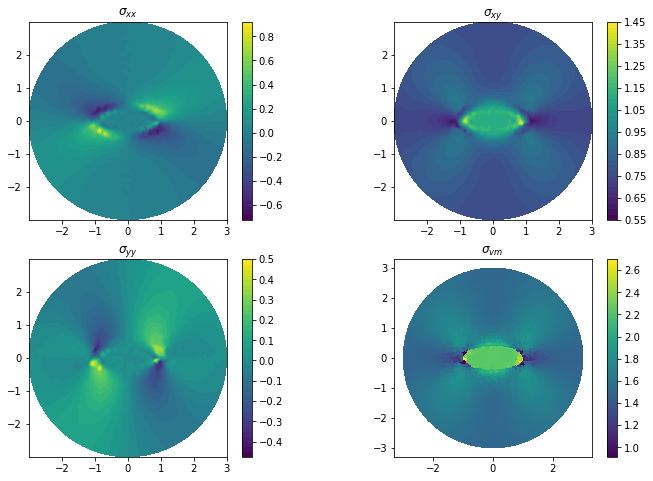

In [29]:
res_treat.plot_all_stress(True)

# VI - Analyze the influence of the external radius R_out on the values of the strains inside the inclusion.

In [30]:
## maillage 

a,b=1,1
gamma =2
k_resolution=3
mesh,subdomain_data,dx,ds = creation_maillage(a,b,gamma,k_resolution)
## parametre 
# force volumique :
rho,g = 1.0,0.0
# dimensions du disque 
R_in,R_out = a,a*gamma
#caracteristique des materiaux 
E_m,ν_m = 1.0,0.3
E_i,ν_i = 10*E_m,0.3
## bondari condition 
ud = df.Expression(('x[1]', 'x[0]'), degree =1)
##fonction space
V,u,v =espace_des_fonction(mesh=mesh,degree = 1)
# creation du probleme :
Prblm = EshelbyDisk_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_out,E_m,E_i, ν_i, ν_m,ud)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


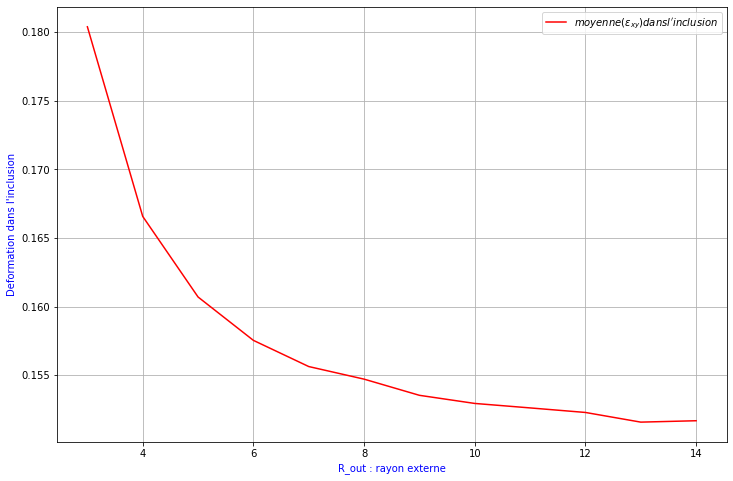

[0.18040078 0.16657242 0.16069564 0.1575326  0.15562378 0.15470553
 0.15352622 0.15293359 0.15260761 0.15227602 0.15157094 0.15167235]


In [31]:
%time
eps_xx_moy_inclusion = np.array([])
eps_xy_moy_inclusion = np.array([])
eps_yy_moy_inclusion = np.array([])
Gamma =np.arange(3,15)

for gamma in Gamma :
    mesh,subdomain_data,dx,ds = creation_maillage(a,b,gamma,k_resolution)
    V,u,v =espace_des_fonction(mesh=mesh,degree = 1)
    R_out =a*gamma
    Prblm = EshelbyDisk_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_out,E_m,E_i, ν_i, ν_m,ud)
    usol=Prblm.resolution()
    res_treat = Eshelby_Post_treat(mesh,a,b,usol,E_m,E_i, ν_i, ν_m)
    esp_vec_moy_inclusion =res_treat.average_strain(dx(INHOMOGENEITY_ID),choix_print=False)
    eps_xx_mo_inclusiony= np.append(eps_xx_moy_inclusion,esp_vec_moy_inclusion[0])
    eps_xy_moy_inclusion= np.append(eps_xy_moy_inclusion,esp_vec_moy_inclusion[1])
    eps_yy_moy_inclusion= np.append(eps_yy_moy_inclusion,esp_vec_moy_inclusion[2])

#plt.plot(Gamma,eps_xx_moy)
plt.plot(Gamma,eps_xy_moy_inclusion,label ="$moyenne(\epsilon_{xy}) dans l'inclusion $",color ="red")
#plt.plot(Gamma,eps_yy_moy_inclusion)
#plt.plot(resolutions_du_maillage_log,Error_H1_PI_log[2,:],label ="Pour P3")
plt.xlabel("R_out : rayon externe",color="blue")
plt.ylabel("Deformation dans l'inclusion",color="blue")
plt.grid()
plt.legend()
plt.show()
print(eps_xy_moy_inclusion)  

In [32]:

mu_m = E_m/(2*(1+ν_m))
mu_i = E_i/(2*(1+ν_i))
q = (3-4*ν_m)/(8*mu_m*(1-ν_m))
b = 1/(1+2*q*(mu_i-mu_m))
print('théoriquement, eps_xy_inclusion = ',b)

théoriquement, eps_xy_inclusion =  0.14736842105263154


# VII- Inclusion Fome complexe  (NON Elipsoidal)

The area of the region everywhere is 451.47
The area of the region 2 is 23.50
The area of the region 1 is 427.97


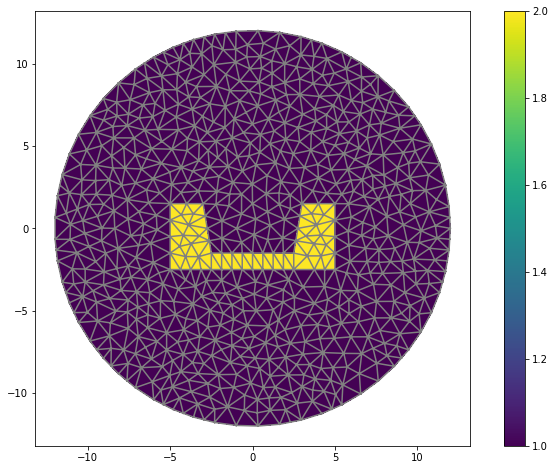

In [33]:
MATRIX_ID = 1
INHOMOGENEITY_ID = 2

a=1
gamma=3
def creation_maillage(a=2.0,b=1,gamma=10, k_resolution=2.0): 
    
    R =a*gamma
    h = a/k_resolution # Size of elements
    
    circle_perimeter = 2*np.pi*R
    e_sqr = 1.-min(a, b)/max(a, b)
    Rectangle_perimeter = 2*(a+b) ####
    origin = dolfin.Point(0., 0.)
    l=0.5*a
    L=0.5*b
    P1 = dolfin.Point(l, L)
    P2 = dolfin.Point(-l, -L)
   # Omega_i = mshr.Rectangle(P1,P2)
    
    domain_vertices  =  [ df.Point ( -5 ,  -2.5), 
                   df.Point ( 5 ,   -2.5), 
                   df.Point ( 5 ,  1.5 ), 
                   df.Point ( 3 ,  1.5), 
                   df.Point ( 2.5 ,  -1.5 ), 
                   df.Point ( -2.5 ,  -1.5 ), 
                   df.Point ( -3 ,  1.5 ), 
                   df.Point ( -5 ,  1.5),
                   df.Point ( -5 ,  -2.5 )]
    Omega_i = mshr.Polygon(domain_vertices)
    
    
    

    Omega = mshr.Circle(origin, R,int(np.ceil(circle_perimeter/h)))
    Omega.set_subdomain(MATRIX_ID, Omega-Omega_i)
    Omega.set_subdomain(INHOMOGENEITY_ID, Omega_i)
    mesh = mshr.generate_mesh(Omega, resolution=2*R/h)
    subdomain_data = dolfin.MeshFunction("size_t", mesh, dim=mesh.geometric_dimension(), value=mesh.domains())
    dx = dolfin.Measure("dx",
                    domain=mesh,
                    subdomain_data=subdomain_data)
    ds = dolfin.Measure("ds", domain=mesh)
    return mesh,subdomain_data,dx,ds

a,b =4,2
gamma =3
k_resolution=3
mesh,subdomain_data,dx,ds = creation_maillage(a,b,gamma,k_resolution)
R    =  gamma *a
dolfin.plot(mesh)


plt.colorbar(dolfin.plot(subdomain_data))
#dolfin.plot(mesh)
keys = ["everywhere", INHOMOGENEITY_ID, MATRIX_ID]
areas = {key: dolfin.assemble(dolfin.Constant(1.)*dx(key)) for key in keys}
areas
for region, area in areas.items():  
        print("The area of the region {} is {:04.2f}".format(region, area))

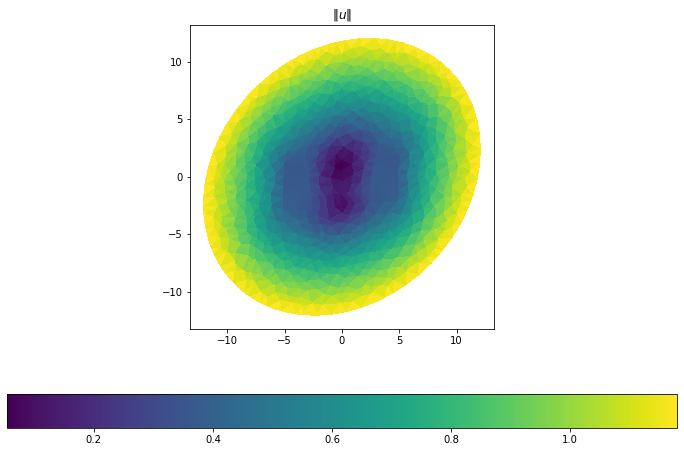

In [34]:
R_ext =max(a,b)*gamma
V,u,v =espace_des_fonction(mesh=mesh,degree = 2)
# creation du probleme :
ud = df.Expression(('x[1]', 'x[0]'), degree =2)
E_m,ν_m = 1.0,0.3
E_i,ν_i = 10*E_m,0.3
Prblm = EshelbyDisk_num(mesh,keys,dx,ds,V,u,v,rho,g,R_in,R_ext,E_m,E_i, ν_i, ν_m,ud)
#resolution 
usol=Prblm.resolution()
#affichage :
plt.colorbar(df.plot((10**(-1))*usol, mode="displacement",title=r"$\Vert u \Vert$",\
                     wireframe = True),orientation="horizontal")
plt.show()

la valeur maximale de la deformation  $ε_{xx} $=  0.6609123203532892
la valeur maximale de la deformation  $ε_{xy} $=  1.4280751820531923
la valeur maximale de la deformation  $ε_{yy} $=  0.7939173373750521


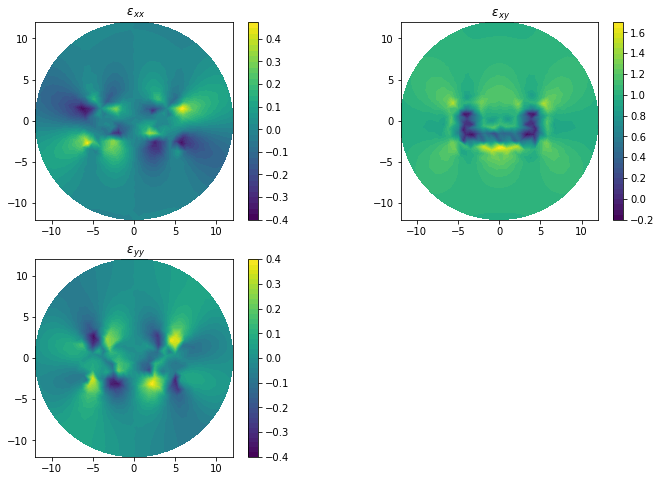

In [35]:
res_treat = Eshelby_Post_treat(mesh,a,b,usol,E_m,E_i, ν_i, ν_m)
res_treat.plot_all_strain()

In [36]:
print("*Dans l'inclusion :")
res_treat.average_strain(dx(INHOMOGENEITY_ID))
print('')
res_treat.diviation_strains(dx(INHOMOGENEITY_ID))
print('')
print('')
print("Dans la Matrix:")
res_treat.average_strain(dx(MATRIX_ID))
print('')
res_treat.diviation_strains(dx(MATRIX_ID))

*Dans l'inclusion :
  la deformation moyenne suivant  ε_{xx} est < e11>= 3.372056292387266e-05
  la deformation moyenne suivant  ε_{xy} est < e12>= 0.15394217284473205
  la deformation moyenne suivant  ε_{yy} est < e22>= 5.447669830483095e-06

  la deviation  suivant ε_{xx} est = 1104.4083879097013
  la deviation  suivant ε_{xy} est = 0.22246204554721016
  la deviation  suivant ε_{yy} est = 6747.034440662477


Dans la Matrix:
  la deformation moyenne suivant  ε_{xx} est < e11>= -1.8515931181515804e-06
  la deformation moyenne suivant  ε_{xy} est < e12>= 1.0464569601548017
  la deformation moyenne suivant  ε_{yy} est < e22>= -2.99131067552653e-07

  la deviation  suivant ε_{xx} est = -33451.54251739615
  la deviation  suivant ε_{xy} est = 0.052575365390218426
  la deviation  suivant ε_{yy} est = -185546.9732835412


array([-3.34515425e+04,  5.25753654e-02, -1.85546973e+05])